<h1 style='text-align: center; font-weight: bolder'> 
    Análisis de Supervivencia
</h1>

## **Librerías**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
pd.options.display.max_columns = False

In [3]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

In [4]:
from sksurv.datasets import load_veterans_lung_cancer

In [5]:
from sksurv.nonparametric import kaplan_meier_estimator
from sksurv.linear_model import CoxPHSurvivalAnalysis

In [6]:
from sksurv.compare import compare_survival
from sksurv.metrics import concordance_index_censored, cumulative_dynamic_auc

## **Datos**

In [7]:
X, y = load_veterans_lung_cancer()

In [8]:
X.head()

,Age_in_years,Celltype,Karnofsky_score,Months_from_Diagnosis,Prior_therapy,Treatment
0,69.0,squamous,60.0,7.0,no,standard
1,64.0,squamous,70.0,5.0,yes,standard
2,38.0,squamous,60.0,3.0,no,standard
3,63.0,squamous,60.0,9.0,yes,standard
4,65.0,squamous,70.0,11.0,yes,standard


In [9]:
pd.DataFrame(y).sample(5)

,Status,Survival_in_days
62,True,156.0
44,True,10.0
117,True,48.0
0,True,72.0
99,True,8.0


## **Estimadores**

### **1. Kaplan-Meier**

The Kaplan-Meier estimator is a non-parametric statistic to estimate the survival function that works well with right-censored data.

The main assumption of the Kaplan-Meier estimator is that censored data has the same probability of survival as uncensored data. 

In [10]:
time, survival_prob = kaplan_meier_estimator(y['Status'], y['Survival_in_days'])

In [11]:
time

array([  1.,   2.,   3.,   4.,   7.,   8.,  10.,  11.,  12.,  13.,  15.,
        16.,  18.,  19.,  20.,  21.,  22.,  24.,  25.,  27.,  29.,  30.,
        31.,  33.,  35.,  36.,  42.,  43.,  44.,  45.,  48.,  49.,  51.,
        52.,  53.,  54.,  56.,  59.,  61.,  63.,  72.,  73.,  80.,  82.,
        83.,  84.,  87.,  90.,  92.,  95.,  97.,  99., 100., 103., 105.,
       110., 111., 112., 117., 118., 122., 123., 126., 132., 133., 139.,
       140., 143., 144., 151., 153., 156., 162., 164., 177., 182., 186.,
       200., 201., 216., 228., 231., 242., 250., 260., 278., 283., 287.,
       314., 340., 357., 378., 384., 389., 392., 411., 467., 553., 587.,
       991., 999.])

In [12]:
survival_prob

array([0.98540146, 0.97810219, 0.97080292, 0.96350365, 0.94160584,
       0.91240876, 0.89781022, 0.89051095, 0.87591241, 0.86131387,
       0.84671533, 0.83941606, 0.81751825, 0.80291971, 0.78832117,
       0.77372263, 0.76642336, 0.75182482, 0.72992701, 0.72255401,
       0.71518101, 0.70043501, 0.68568901, 0.67831601, 0.67094301,
       0.66357001, 0.65619701, 0.64882401, 0.64145101, 0.63407801,
       0.62670501, 0.61933201, 0.59721301, 0.57509401, 0.56772101,
       0.55297501, 0.54560201, 0.53822901, 0.53085601, 0.52348301,
       0.51611001, 0.50873701, 0.493991  , 0.486618  , 0.486618  ,
       0.47913157, 0.47164514, 0.46403796, 0.45643078, 0.44121642,
       0.44121642, 0.42573515, 0.41799451, 0.41010782, 0.40206649,
       0.39402516, 0.3779425 , 0.36990117, 0.35381851, 0.34577718,
       0.33773585, 0.33773585, 0.32949839, 0.32126093, 0.31302347,
       0.30478601, 0.29654855, 0.28831109, 0.28007363, 0.27183617,
       0.26359871, 0.25536125, 0.23888633, 0.23064887, 0.22241

#### **Survival function**

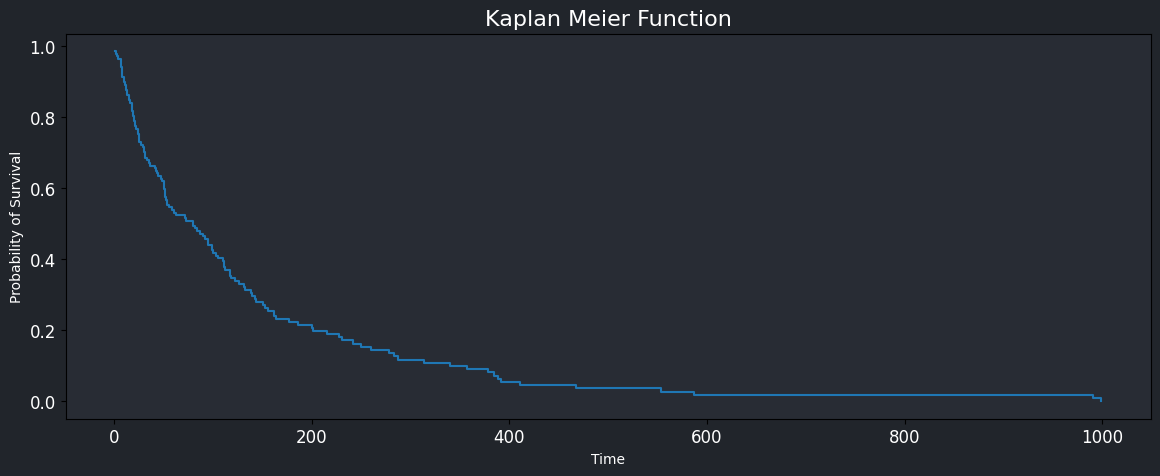

In [13]:
fig, ax = plt.subplots(figsize = (14, 5))

fig.patch.set_facecolor('#21252b') 
ax.set_facecolor('#282c34') 

plt.title('Kaplan Meier Function', fontsize=16, color='white')

ax.step(time, survival_prob, where='post')

ax.set_xlabel('Time', color='white')
plt.xticks(color='white', size=12)

ax.set_ylabel('Probability of Survival', color='white')
plt.yticks(color='white', size=12)

plt.show()

#### **Survival function for different groups**

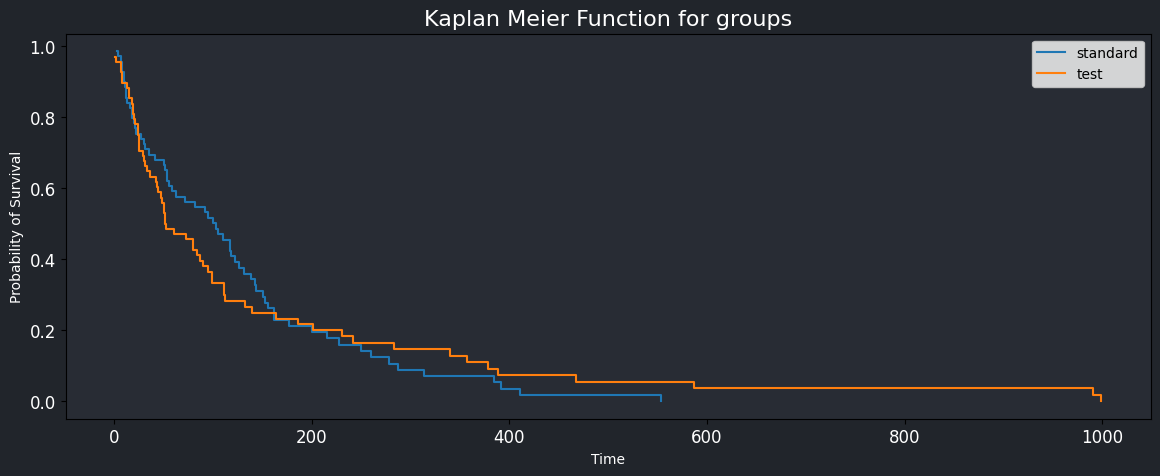

In [14]:
fig, ax = plt.subplots(figsize = (14, 5))

plt.title('Kaplan Meier Function for groups', fontsize=16, color='white')

fig.patch.set_facecolor('#21252b') 
ax.set_facecolor('#282c34') 

for treatment_type in ('standard', 'test'):
    mask_treatment = X['Treatment'] == treatment_type
    
    time, survival_prob = kaplan_meier_estimator(
        y['Status'][mask_treatment],
        y['Survival_in_days'][mask_treatment]
    )
    
    plt.step(time, survival_prob, where='post', label=f'{treatment_type}')

ax.set_xlabel('Time', color='white')
plt.xticks(color='white', size=12)

ax.set_ylabel('Probability of Survival', color='white')
plt.yticks(color='white', size=12)

plt.legend()

plt.show()

#### **Logrank Test**

In [15]:
group_indicator = X.loc[:, 'Treatment']
groups = group_indicator.unique()

In [16]:
chi2, pvalue = compare_survival(y, group_indicator)

In [17]:
round(chi2, 2)

0.01

In [18]:
round(pvalue, 2)

0.93

This outputs a p-value of 0.93. Since it is not less than 0.05, we fail to reject the null hypothesis and conclude that the survival curves are not significantly different. Therefore, the treatment type did not help patients live longer.

### **2. Regresión de Cox**

The Cox Porportional Hazard model is one of the models that can evaluate the effect of different factors on survival. That way, we can determine what factors can improve survival, and what factors reduce the chance of survival.

An important assumption of this model is that hazard is proportional, and that proportion is independent of time. 

In [19]:
X_dummies = pd.get_dummies(X, drop_first=True)

In [20]:
X_dummies.replace({
    True: 1,
    False: 0
}, inplace=True)

#### **The Model**

In [21]:
cox = CoxPHSurvivalAnalysis()

In [22]:
cox.fit(X_dummies, y)

CoxPHSurvivalAnalysis()

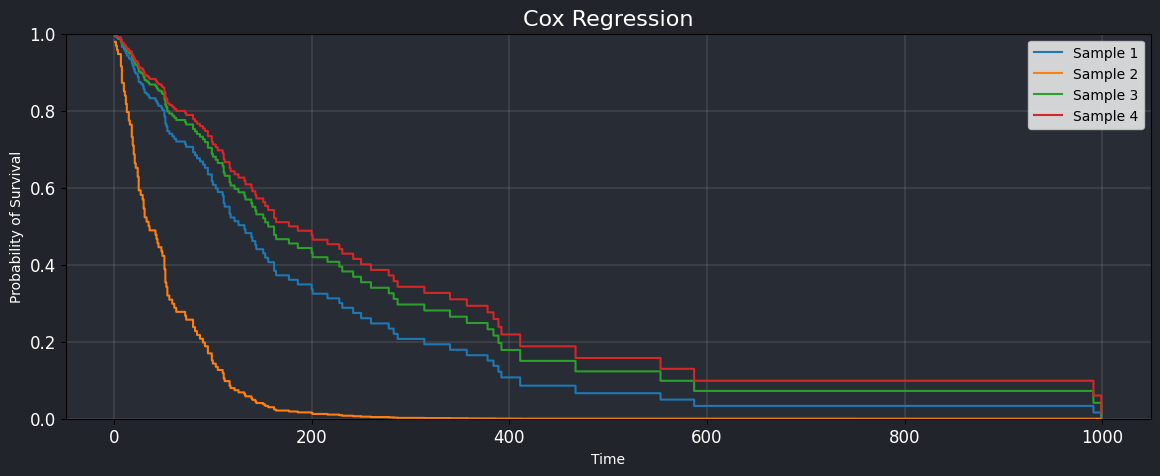

In [23]:
pred_surv = cox.predict_survival_function(X_dummies.sample(4))
time_points = np.arange(1, 1000)

fig, ax = plt.subplots(figsize = (14, 5))

plt.title('Cox Regression', fontsize=16, color='white')

fig.patch.set_facecolor('#21252b') 
ax.set_facecolor('#282c34') 

for i, surv_func in enumerate(pred_surv):
    plt.step(time_points, surv_func(time_points), where='post', label=f'Sample {i+1}')
    
ax.set_xlabel('Time', color='white')
plt.xticks(color='white', size=12)

ax.set_ylabel('Probability of Survival', color='white')
plt.yticks(color='white', size=12)

plt.ylim(0, 1)

plt.grid(linewidth=0.2)

plt.legend()

plt.show()

#### **Indice de Concordancia**

In [24]:
round(cox.score(X_dummies, y), 2)

0.74

#### **Evaluate  with  dynamic ROC AUC**

In [25]:
X_train, X_test, y_train, y_test = train_test_split(
    X_dummies, 
    y, 
    random_state=13, 
    test_size=0.2,
    stratify=y['Status']
)

In [26]:
cph = CoxPHSurvivalAnalysis()
cph.fit(X_train, y_train)

CoxPHSurvivalAnalysis()

In [27]:
time_interval = np.arange(8, 184, 7)

In [28]:
cph_risk_scores = cph.predict(X_test)

In [29]:
cph_auc, cph_mean_auc = cumulative_dynamic_auc(y_train, y_test, cph_risk_scores, time_interval)

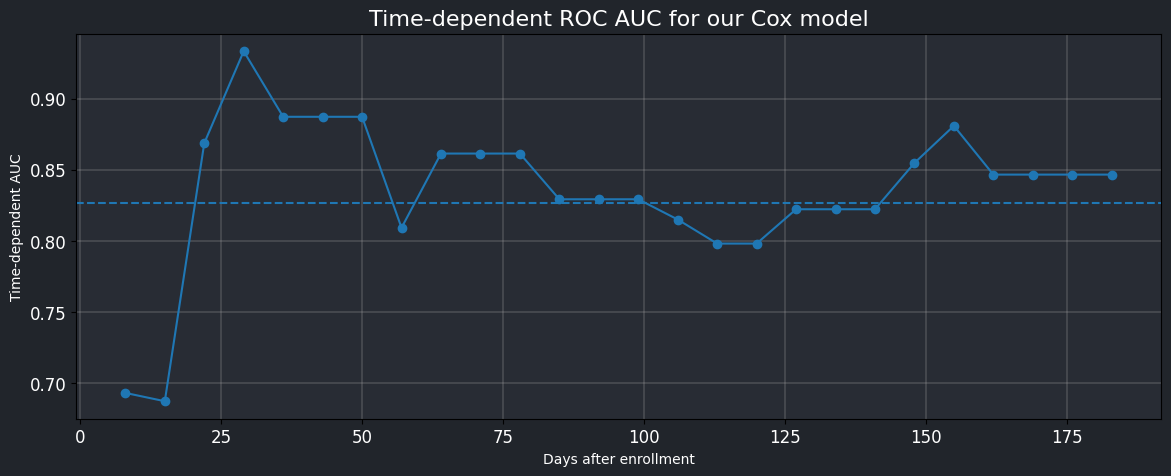

In [31]:
fig, ax = plt.subplots(figsize = (14, 5))

fig.patch.set_facecolor('#21252b') 
ax.set_facecolor('#282c34') 

plt.title('Time-dependent ROC AUC for our Cox model', fontsize=16, color='white')

ax.plot(time_interval, cph_auc, marker='o')
ax.axhline(cph_mean_auc, ls='--')

ax.set_xlabel('Days after enrollment', color='white')
plt.xticks(color='white', size=12)

ax.set_ylabel('Time-dependent AUC', color='white')
plt.yticks(color='white', size=12)

plt.grid(linewidth=0.3)

plt.show()

The performance of the model remains constant over time, oscillating around the average value of the AUC

## **Bibliografías**
- The Complete Introduction to Survival Analysis in Python https://towardsdatascience.com/the-complete-introduction-to-survival-analysis-in-python-7523e17737e6